# Домашнее задание:
## Сравнение детекторов на примере детекции игроков в спорте

Необходимо обучить на целевом датасете (игроки в спорте) два типа детекторов: 1) Detectron2 (семейтсво R-CNN) и 2) Ultralytics (семейство YOLO). После обучения нужно замерить метрику mAP для разных моделей и сравнить результаты. Задание будет принятно только после выполнения всех 5 задач. Также необходимо продемонстрировать код и сводную таблицу с результатами.

### Задачи:
1) Обучить любую модель из [Detectron2](https://github.com/facebookresearch/detectron2) детектировать игроков в баскетбольном матче. Число классов: 2 (две команды). В качестве начальной модели взять любую из [предобученных моделей](https://github.com/facebookresearch/detectron2/blob/main/MODEL_ZOO.md) (Faster R-CNN или RetinaNet). Перед обучением, необходимо привести целевой датасет к формату detectron2. Пример того, как обучать Detectron2 на своем датасете можно найти [здесь](https://colab.research.google.com/drive/1Xdm2KrBauT0lEyKFEiLie7nhzXajgEkH?usp=sharing). Посчитать метрику COCO mAP.

2) Обучить любую модель из [Ultralytics](https://github.com/ultralytics/ultralytics) (YOLOv8, YOLOv9, YOLOv10). В качестве начальной модели необходимо взять предобученную модель (например, yolov8n.pt). Необходимо также адаптировать целевой датасет к формату Ultralytics. Пример того, как обучить YOLOv8 на своем датасете можно найти [здесь](https://colab.research.google.com/drive/1fPZT1d-EBuYdDgXAmfnlKhkFilRnrjGj?usp=sharing). Посчитать метрику COCO mAP.

3) Обучить модель из Ultralytics с нуля (from scratch), аналогично п.2.

4) Протестировать модель "из коробки" из Ultralytics (т.е. без дообучения) и посчитать mAP для тестовой выборки.

5) Свести в единую таблицу результаты всех моделей (по метрике mAP), сравнить и сделать выводы (точность, скорость обучения, эффект предобучения, удобство работы с фреймворком (detectron2 и ultralitics).

### Датасет:
Скачайте датасет [otus_basketball_dataset](https://disk.yandex.ru/d/thdvaAKQS3ASXA) и распакуйте. Внутри находятся папки `images_train` (400 изображений) и `images_test` (100 изображений), а также файлы с аннотациями к ним: `anno_train.json` и `anno_test.json`. Файлы с аннотациями имеет следующую структуру:
```
image_name: {
     player_id: {
             'box': [x,y,w,h],
             'team': int
     }
     .....
}
....
```
Здесь `image_name` - имя изображения в соответствующей папке,<br>
`player_id` - id игрока в текущем изображении (в данном задании id не важен),<br>
`'box': [x,y,w,h]` - bounding box соответствующего игрока (координаты нормализованы от 0 до 1, поэтому их нужно домножить на размеры изображения, чтобы перевести их в целые координаты фрейма),<br>
`'team': int` - id команды к которой принадлежит игрок  в данном кадре (может принимать значения 0 или 1).

In [6]:
import torch
print(torch.__version__)  
print(torch.cuda.is_available())

2.7.0+cu128
True


In [5]:
%matplotlib inline
import ultralytics
import json
import os
from pathlib import Path
import shutil
from ultralytics import YOLO
import os
import cv2
import yaml
import random
import matplotlib.pyplot as plt
ultralytics.checks()

from IPython.display import Image

Ultralytics 8.3.145  Python-3.11.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4090, 24564MiB)
Setup complete  (16 CPUs, 27.7 GB RAM, 800.3/951.6 GB disk)


In [27]:
# Пути к данным
DATA_DIR = "Data"
IMAGES_TRAIN_DIR = os.path.join(DATA_DIR, "images_train")
IMAGES_TEST_DIR = os.path.join(DATA_DIR, "images_test")
ANNO_TRAIN_PATH = os.path.join(DATA_DIR, "anno_train.json")
ANNO_TEST_PATH = os.path.join(DATA_DIR, "anno_test.json")

# Пути для сохранения разметки
LABELS_TRAIN_DIR = os.path.join(DATA_DIR, "labels_train")
LABELS_TEST_DIR = os.path.join(DATA_DIR, "labels_test")

# Создаем папки для разметки
os.makedirs(LABELS_TRAIN_DIR, exist_ok=True)
os.makedirs(LABELS_TEST_DIR, exist_ok=True)

In [28]:
def convert_annotations(anno_path, images_dir, labels_dir):
    with open(anno_path, 'r') as f:
        annotations = json.load(f)

    for img_name, objects in annotations.items():
        # Путь к .txt файлу
        label_file = os.path.join(labels_dir, os.path.splitext(img_name)[0] + ".txt")
        
        # Проверяем, существует ли изображение
        img_path = os.path.join(images_dir, img_name)
        if not os.path.exists(img_path):
            print(f"Изображение {img_name} не найдено в {images_dir}. Пропускаем.")
            continue
        
        # Записываем bounding box'ы
        with open(label_file, 'w') as f:
            for obj_id, data in objects.items():
                team = data['team']
                box = data['box']  # [x_center, y_center, width, height]

                # Проверяем, что все значения в диапазоне [0, 1]
                if any(not (0 <= x <= 1) for x in box):
                    print(f"Некорректные координаты в {img_name}, объект {obj_id}. Пропускаем.")
                    continue

                # Формат YOLO: class_id x_center y_center width height
                line = f"{team} {' '.join(map(str, box))}\n"
                f.write(line)

# Обработка train и test
convert_annotations(ANNO_TRAIN_PATH, IMAGES_TRAIN_DIR, LABELS_TRAIN_DIR)
convert_annotations(ANNO_TEST_PATH, IMAGES_TEST_DIR, LABELS_TEST_DIR)

print("Разметка успешно преобразована!")

Некорректные координаты в 020017.jpeg, объект 2. Пропускаем.
Некорректные координаты в 020017.jpeg, объект 15. Пропускаем.
Некорректные координаты в 029147.jpeg, объект 2. Пропускаем.
Некорректные координаты в 037892.jpeg, объект 15. Пропускаем.
Некорректные координаты в 040007.jpeg, объект null. Пропускаем.
Некорректные координаты в 040155.jpeg, объект 1. Пропускаем.
Некорректные координаты в 047533.jpeg, объект 31. Пропускаем.
Некорректные координаты в 055446.jpeg, объект 0. Пропускаем.
Некорректные координаты в 081921.jpeg, объект 20. Пропускаем.
Некорректные координаты в 094774.jpeg, объект 2. Пропускаем.
Разметка успешно преобразована!


In [73]:
# Пути к данным
IMAGES_DIR = "dataset/images/train"  # Папка с изображениями
LABELS_DIR = "dataset/labels/train"  # Папка с .txt файлами

# Имена классов (в порядке class_id)
CLASS_NAMES = ['team0', 'team1']
CLASS_COLORS = [(0, 255, 0), (255, 0, 0)]  # team0 - зеленый, team1 - синий

In [105]:
def draw_bounding_boxes(image_path, label_path):
    # Загрузка изображения
    image = cv2.imread(image_path)

    if image is None:
        print(f"Не удалось загрузить изображение {image_path}")
        return None

    h, w, _ = image.shape

    # Рисование bounding box'ов
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            lines = f.readlines()

        for line in lines:
            parts = line.strip().split()
            if not parts:
                continue

            class_id = int(parts[0])
            x_center = float(parts[1])
            y_center = float(parts[2])
            width = float(parts[3])
            height = float(parts[4])

            # Переводим нормализованные координаты в пиксели
            x1 = int(x_center * w)
            y1 = int(y_center * h)
            x2 = int((x_center + width) * w)
            y2 = int((y_center + height) * h)

            color = CLASS_COLORS[class_id]
            label = CLASS_NAMES[class_id]

            # Рисуем bounding box
            cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
            
            # Подпись класса
            cv2.putText(image, label, (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    else:
        print(f"Файл аннотации {label_path} не найден!")

    return image

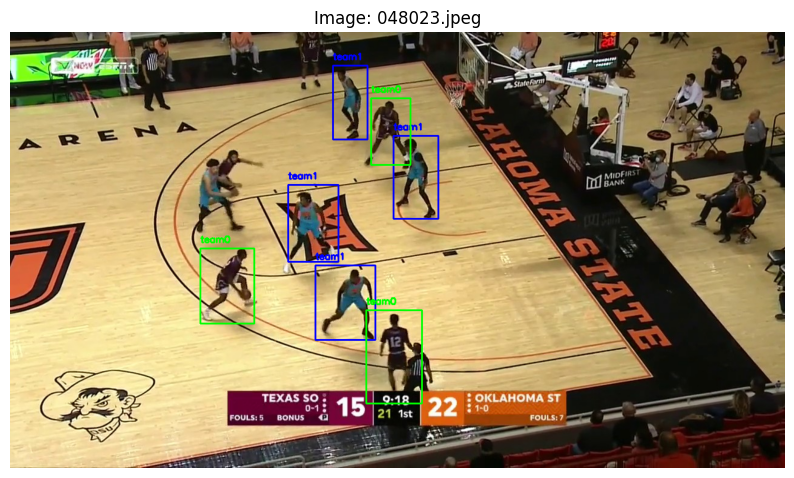

In [107]:
# Получаем список изображений
image_files = [f for f in os.listdir(IMAGES_DIR) if f.endswith(('.jpg', '.jpeg', '.png'))]

if not image_files:
    print("Нет изображений в указанной папке.")
else:
    # Выбираем случайное изображение
    random_image_file = random.choice(image_files)
    image_path = os.path.join(IMAGES_DIR, random_image_file)
    label_path = os.path.join(LABELS_DIR, os.path.splitext(random_image_file)[0] + ".txt")

    # Рисуем bounding box'ы
    annotated_image = draw_bounding_boxes(image_path, label_path)

    if annotated_image is not None:
        # Преобразуем из BGR в RGB для matplotlib
        annotated_image = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)

        # Отображаем изображение через matplotlib
        plt.figure(figsize=(10, 8))
        plt.imshow(annotated_image)
        plt.title(f"Image: {random_image_file}")
        plt.axis("off")
        plt.show()

In [112]:
# Загрузите модель
model = YOLO("yolo11m.pt") 

In [115]:

# Обучение
model.train(
    data="data.yaml",
    epochs=50,
    imgsz=640,
    batch=16,
    device=0,  # 0 - первый GPU
    name="basketball_model"
)

Ultralytics 8.3.145  Python-3.11.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4090, 24564MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=basketball_model2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrai

100%|██████████| 5.35M/5.35M [00:00<00:00, 7.05MB/s]


AMP: checks passed 
train: Fast image access  (ping: 0.10.1 ms, read: 2313.1805.4 MB/s, size: 208.1 KB)


train: Scanning C:\Users\khari\OneDrive\Документы\GirRep\OtusCV\Lesson 17\Homework\dataset\labels\train... 400 images, 0 backgrounds, 0 corrupt: 100%|██████████| 400/400 [00:00<00:00, 1423.37it/s]

train: New cache created: C:\Users\khari\OneDrive\\GirRep\OtusCV\Lesson 17\Homework\dataset\labels\train.cache


val: Fast image access  (ping: 0.10.0 ms, read: 1830.3172.9 MB/s, size: 220.5 KB)


val: Scanning C:\Users\khari\OneDrive\Документы\GirRep\OtusCV\Lesson 17\Homework\dataset\labels\test... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<00:00, 1343.61it/s]

val: New cache created: C:\Users\khari\OneDrive\\GirRep\OtusCV\Lesson 17\Homework\dataset\labels\test.cache


Plotting labels to runs\detect\basketball_model2\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\basketball_model2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50       8.4G      2.761      3.393      2.261        193        640: 100%|██████████| 25/25 [00:12<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.70it/s]

                   all        100        658     0.0761      0.238     0.0452     0.0101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50       8.4G      2.025      2.209      1.671        219        640: 100%|██████████| 25/25 [00:06<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.83it/s]

                   all        100        658     0.0109      0.244    0.00595     0.0023



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      8.45G      1.932      2.015      1.641        178        640: 100%|██████████| 25/25 [00:06<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.01it/s]

                   all        100        658       0.23       0.59      0.232     0.0991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      8.51G      1.909      1.889      1.578        182        640: 100%|██████████| 25/25 [00:06<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.76it/s]

                   all        100        658      0.165      0.269     0.0953     0.0201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      8.58G      1.822      1.827       1.53        226        640: 100%|██████████| 25/25 [00:05<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.56it/s]

                   all        100        658      0.227      0.405      0.178     0.0617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      8.64G      1.824      1.785      1.515        243        640: 100%|██████████| 25/25 [00:05<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.59it/s]

                   all        100        658      0.315      0.469      0.347      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      8.71G      1.713      1.689      1.427        189        640: 100%|██████████| 25/25 [00:05<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.83it/s]

                   all        100        658      0.297      0.715      0.306      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      8.84G      1.683      1.634      1.425        170        640: 100%|██████████| 25/25 [00:06<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.64it/s]

                   all        100        658      0.284      0.684      0.315      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      8.96G       1.63      1.588      1.406        229        640: 100%|██████████| 25/25 [00:06<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.49it/s]

                   all        100        658      0.273      0.509      0.316      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      9.03G      1.623      1.573      1.415        218        640: 100%|██████████| 25/25 [00:05<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.75it/s]

                   all        100        658      0.294      0.651      0.339      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      9.15G      1.571      1.557      1.363        209        640: 100%|██████████| 25/25 [00:05<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.59it/s]

                   all        100        658      0.355      0.643       0.38       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      9.28G      1.596      1.513      1.346        214        640: 100%|██████████| 25/25 [00:05<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.67it/s]

                   all        100        658      0.291      0.659      0.302      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      9.39G      1.576      1.533      1.378        179        640: 100%|██████████| 25/25 [00:06<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.20it/s]

                   all        100        658      0.283      0.715      0.288      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      9.52G       1.56      1.491      1.349        251        640: 100%|██████████| 25/25 [00:06<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.30it/s]

                   all        100        658      0.338        0.6      0.398      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      9.64G      1.508      1.477      1.316        192        640: 100%|██████████| 25/25 [00:06<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.43it/s]

                   all        100        658      0.303      0.656      0.324      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      9.71G      1.477      1.481      1.321        223        640: 100%|██████████| 25/25 [00:06<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.43it/s]

                   all        100        658      0.349      0.696      0.398       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      9.84G      1.482      1.428      1.291        194        640: 100%|██████████| 25/25 [00:06<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.50it/s]

                   all        100        658       0.27        0.7      0.261      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      9.96G      1.459       1.44      1.293        185        640: 100%|██████████| 25/25 [00:06<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.31it/s]

                   all        100        658      0.357      0.701      0.391      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      10.1G      1.459      1.429      1.301        162        640: 100%|██████████| 25/25 [00:06<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.39it/s]

                   all        100        658      0.327      0.715       0.35      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      10.2G      1.415      1.412      1.263        208        640: 100%|██████████| 25/25 [00:06<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.32it/s]

                   all        100        658       0.37      0.665      0.401      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      10.3G      1.448      1.384      1.271        229        640: 100%|██████████| 25/25 [00:06<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.39it/s]

                   all        100        658      0.326      0.681      0.344      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      10.4G      1.392      1.368      1.258        169        640: 100%|██████████| 25/25 [00:06<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.27it/s]

                   all        100        658      0.372      0.673      0.394      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      10.5G      1.445      1.374      1.284        163        640: 100%|██████████| 25/25 [00:06<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.76it/s]

                   all        100        658      0.314      0.709      0.394      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      10.6G      1.413      1.372      1.262        189        640: 100%|██████████| 25/25 [00:06<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.51it/s]

                   all        100        658       0.35      0.639      0.351      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      10.8G       1.36       1.31      1.233        158        640: 100%|██████████| 25/25 [00:05<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.75it/s]

                   all        100        658      0.342      0.728      0.388      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      10.9G      1.353      1.308      1.225        218        640: 100%|██████████| 25/25 [00:05<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.82it/s]

                   all        100        658      0.349      0.698      0.395      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50        11G      1.346      1.302      1.218        196        640: 100%|██████████| 25/25 [00:05<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.76it/s]

                   all        100        658      0.312      0.743       0.35      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      11.1G      1.334      1.277      1.227        191        640: 100%|██████████| 25/25 [00:05<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.81it/s]

                   all        100        658      0.393      0.679      0.421      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      11.2G       1.33      1.264      1.206        179        640: 100%|██████████| 25/25 [00:05<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.66it/s]

                   all        100        658       0.35      0.734      0.394      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      11.3G       1.29      1.226      1.196        204        640: 100%|██████████| 25/25 [00:05<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.65it/s]

                   all        100        658      0.447      0.698      0.459      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      11.5G      1.333      1.254       1.23        222        640: 100%|██████████| 25/25 [00:05<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.87it/s]

                   all        100        658       0.35      0.655      0.375      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      11.6G      1.287      1.216      1.189        202        640: 100%|██████████| 25/25 [00:06<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.69it/s]

                   all        100        658      0.358      0.737      0.385      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      11.7G      1.272      1.209      1.181        253        640: 100%|██████████| 25/25 [00:05<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.88it/s]

                   all        100        658      0.389       0.64      0.406       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      11.8G      1.238      1.183      1.161        222        640: 100%|██████████| 25/25 [00:05<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.74it/s]

                   all        100        658      0.387      0.665      0.412      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      11.9G       1.23      1.142      1.161        226        640: 100%|██████████| 25/25 [00:05<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.76it/s]

                   all        100        658      0.399      0.696      0.417      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50        12G      1.204      1.137      1.139        206        640: 100%|██████████| 25/25 [00:06<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.76it/s]

                   all        100        658      0.356      0.667      0.381      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50       8.6G      1.227      1.137       1.17        194        640: 100%|██████████| 25/25 [00:06<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.70it/s]

                   all        100        658      0.424       0.72      0.464      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50       8.6G        1.2      1.119      1.142        206        640: 100%|██████████| 25/25 [00:05<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.63it/s]

                   all        100        658      0.353      0.715      0.371      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50       8.6G       1.17      1.079      1.132        230        640: 100%|██████████| 25/25 [00:06<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.43it/s]

                   all        100        658        0.4      0.665      0.411      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50       8.6G      1.165      1.087       1.13        223        640: 100%|██████████| 25/25 [00:06<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.38it/s]

                   all        100        658      0.398      0.679      0.416      0.236


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50       8.6G      1.159      1.071      1.191        113        640: 100%|██████████| 25/25 [00:06<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.78it/s]

                   all        100        658      0.356      0.701      0.382      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50       8.6G      1.124      1.034      1.179        103        640: 100%|██████████| 25/25 [00:05<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.75it/s]

                   all        100        658      0.439       0.67      0.473       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50       8.6G      1.126      1.005      1.179        108        640: 100%|██████████| 25/25 [00:06<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.68it/s]

                   all        100        658      0.356      0.646      0.387      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50       8.6G      1.099     0.9883      1.156        102        640: 100%|██████████| 25/25 [00:06<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.09it/s]

                   all        100        658      0.374      0.708      0.397      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50       8.6G      1.062     0.9536      1.141        112        640: 100%|██████████| 25/25 [00:06<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.51it/s]

                   all        100        658      0.382      0.644      0.418      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      8.64G      1.054     0.9496      1.122        100        640: 100%|██████████| 25/25 [00:06<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.38it/s]

                   all        100        658      0.398      0.684      0.431      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      8.71G      1.055     0.9532      1.125        115        640: 100%|██████████| 25/25 [00:06<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.46it/s]

                   all        100        658      0.384       0.67        0.4       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      8.84G      1.035     0.9337      1.126        112        640: 100%|██████████| 25/25 [00:06<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.42it/s]

                   all        100        658      0.378      0.682       0.41      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      8.94G      1.017     0.9048      1.125        103        640: 100%|██████████| 25/25 [00:06<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.39it/s]

                   all        100        658      0.391       0.68      0.402      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      9.07G      1.006     0.9106      1.122        111        640: 100%|██████████| 25/25 [00:06<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.46it/s]

                   all        100        658      0.408      0.653      0.422      0.247



50 epochs completed in 0.114 hours.
Optimizer stripped from runs\detect\basketball_model2\weights\last.pt, 40.5MB
Optimizer stripped from runs\detect\basketball_model2\weights\best.pt, 40.5MB

Validating runs\detect\basketball_model2\weights\best.pt...
Ultralytics 8.3.145  Python-3.11.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4090, 24564MiB)
YOLO11m summary (fused): 125 layers, 20,031,574 parameters, 0 gradients, 67.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.64it/s]


                   all        100        658      0.439       0.67      0.473       0.27
                 team0        100        376       0.55      0.745      0.627      0.358
                 team1        100        282      0.329      0.596      0.319      0.183
Speed: 1.3ms preprocess, 2.3ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\basketball_model2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001D162AAA090>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0

In [10]:
# Загрузите обученную модель
model = YOLO("runs/detect/basketball_detection/weights/best.pt")


image 1/1 c:\Users\khari\OneDrive\\GirRep\OtusCV\Lesson 17\Homework\otus_basketball_dataset\valid\images\095894.jpeg: 384x640 5 team0s, 5 team1s, 51.8ms
Speed: 3.0ms preprocess, 51.8ms inference, 82.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 c:\Users\khari\OneDrive\\GirRep\OtusCV\Lesson 17\Homework\otus_basketball_dataset\valid\images\094684.jpeg: 384x640 3 team0s, 1 team1, 10.2ms
Speed: 1.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 c:\Users\khari\OneDrive\\GirRep\OtusCV\Lesson 17\Homework\otus_basketball_dataset\valid\images\081641.jpeg: 384x640 6 team0s, 3 team1s, 10.6ms
Speed: 5.8ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 c:\Users\khari\OneDrive\\GirRep\OtusCV\Lesson 17\Homework\otus_basketball_dataset\valid\images\091692.jpeg: 384x640 5 team0s, 5 team1s, 19.0ms
Speed: 6.1ms preprocess, 19.0ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 6

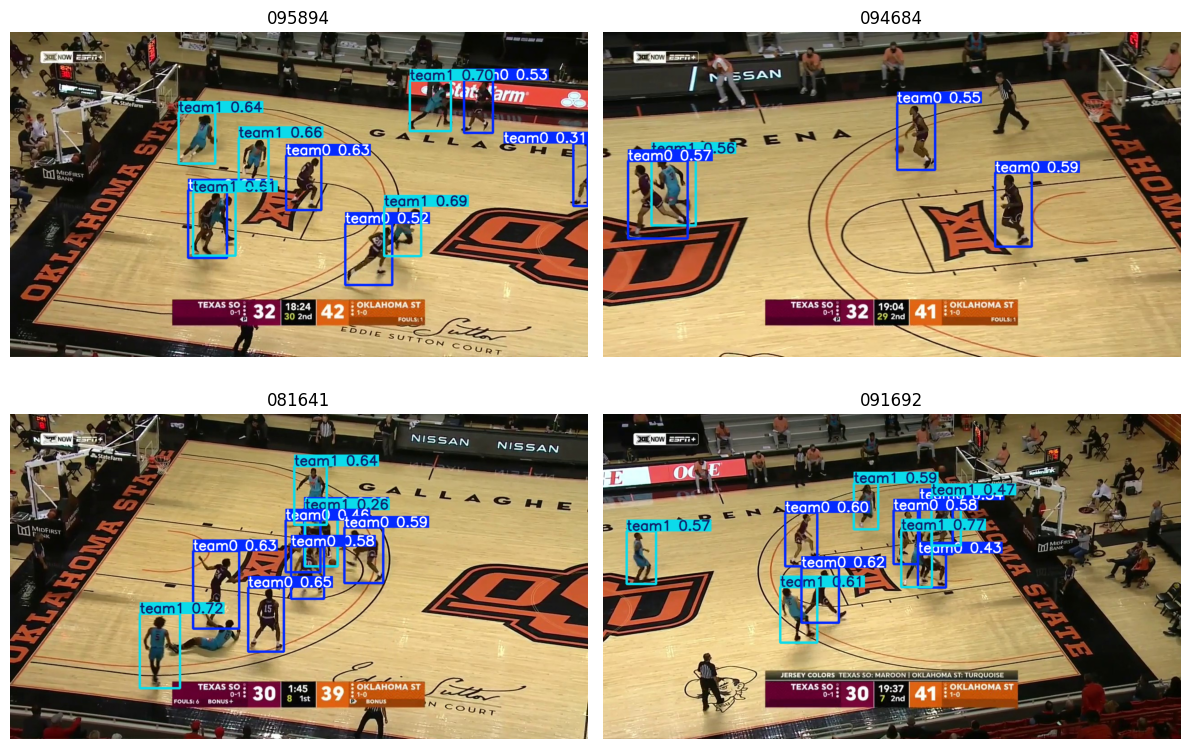

In [19]:
# Папка с тестовыми изображениями
VAL_IMAGES_DIR = "otus_basketball_dataset/valid/images"

# Получаем список изображений
image_files = [f for f in os.listdir(VAL_IMAGES_DIR) if f.endswith(('.jpg', '.jpeg', '.png'))]
random_images = random.sample(image_files, 4)  # Выбираем 4 случайных изображения

# Создаем сетку для отображения
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()

for i, img_file in enumerate(random_images):
    image_path = os.path.join(VAL_IMAGES_DIR, img_file)
    results = model(image_path, imgsz=640)
    result_image = results[0].plot()
    result_image = cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)
    axes[i].imshow(result_image)
    axes[i].set_title(os.path.splitext(img_file)[0])
    axes[i].axis("off")

plt.tight_layout()
plt.show()

In [20]:
# Получите результаты
results = model(image_path)

# Выведите координаты bbox'ов
for result in results:
    boxes = result.boxes.xyxy.cpu().numpy()  # [[x1, y1, x2, y2], ...]
    classes = result.boxes.cls.cpu().numpy()  # [class_id, ...]
    confidences = result.boxes.conf.cpu().numpy()  # [confidence, ...]

    for box, cls, conf in zip(boxes, classes, confidences):
        x1, y1, x2, y2 = map(int, box)
        label = model.names[int(cls)]
        print(f"Class: {label}, Confidence: {conf:.2f}, BBox: [{x1}, {y1}, {x2}, {y2}]")


image 1/1 c:\Users\khari\OneDrive\\GirRep\OtusCV\Lesson 17\Homework\otus_basketball_dataset\valid\images\091692.jpeg: 384x640 5 team0s, 5 team1s, 84.9ms
Speed: 3.3ms preprocess, 84.9ms inference, 4.3ms postprocess per image at shape (1, 3, 384, 640)
Class: team1, Confidence: 0.77, BBox: [660, 257, 728, 383]
Class: team0, Confidence: 0.62, BBox: [439, 340, 522, 462]
Class: team1, Confidence: 0.61, BBox: [392, 383, 474, 506]
Class: team0, Confidence: 0.60, BBox: [403, 218, 474, 337]
Class: team1, Confidence: 0.59, BBox: [555, 153, 609, 255]
Class: team0, Confidence: 0.58, BBox: [643, 213, 697, 332]
Class: team1, Confidence: 0.57, BBox: [52, 259, 117, 376]
Class: team1, Confidence: 0.47, BBox: [727, 179, 792, 291]
Class: team0, Confidence: 0.43, BBox: [697, 308, 759, 384]
Class: team0, Confidence: 0.34, BBox: [701, 190, 774, 310]
